In [46]:
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
asym_matrix = np.load("distance_matrix.npy")
matrix = (asym_matrix + asym_matrix.T) / 2 # make matrix symmetrical for 
condensed = squareform(matrix)
Z = linkage(condensed, method='complete')
optimal_k = 80
labels = fcluster(Z, t=optimal_k, criterion='maxclust')

In [33]:
from collections import defaultdict
clusters = defaultdict(list)
for i, label in enumerate(labels):
    clusters[label].append(i)

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import folium

In [52]:
def find_elbow_with_second_derivative(distance_matrix, method='complete', min_clusters=5, max_clusters=100):
    # Symmetrize and condense
    D_sym = (distance_matrix + distance_matrix.T) / 2
    condensed = squareform(D_sym)
    
    # Linkage
    Z = linkage(condensed, method=method)
    
    # Merge distances
    distances = Z[:, 2]
    reversed_distances = distances[::-1]
    
    # First and second derivatives
    first_deriv = np.diff(reversed_distances)
    second_deriv = np.diff(first_deriv)
    
    # Limit search to first N merge steps to avoid noise
    search_range = second_deriv[min_clusters:max_clusters]

    # Find the elbow point (where second derivative peaks)
    elbow = np.argmax(search_range) + min_clusters
    #optimal_num_clusters = Z.shape[0] - elbow_relative
    
    # Generate flat cluster labels
    labels = fcluster(Z, t=elbow, criterion='maxclust')
    
    return labels, optimal_num_clusters, Z, distances

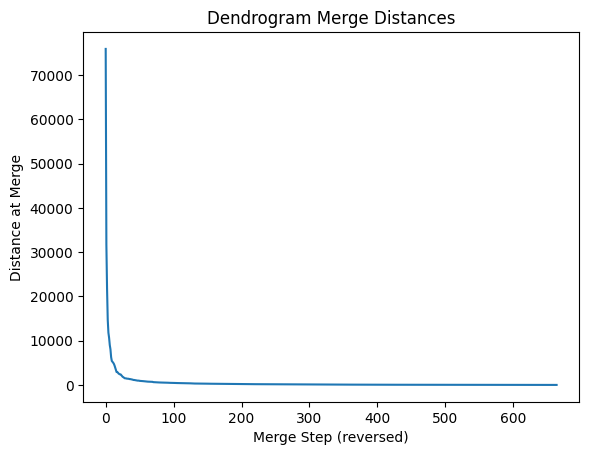

In [20]:
merge_distances = Z[:, 2]
plt.plot(range(len(merge_distances)), merge_distances[::-1])  # Plot in descending order
plt.xlabel("Merge Step (reversed)")
plt.ylabel("Distance at Merge")
plt.title("Dendrogram Merge Distances")
plt.show()

In [81]:
np_labels = np.array(labels)
cluster_indices = np.where(np_labels == 2)[0]
matrix_cluster = matrix[np.ix_(cluster_indices, cluster_indices)]
coords = np.array(coords_list)
cluster_coords = coords[cluster_indices]
cluster_coords_df = pd.DataFrame(cluster_coords)
cluster_coords_df.to_csv("cluster_coords.csv", index=False)
np.save("matrix_cluster.npy", matrix_cluster)

In [74]:
pd.DataFrame(coords_list)

,0,1
0,47.722051,-122.355840
1,47.722051,-122.355840
2,47.721644,-122.355984
3,47.721630,-122.356552
4,47.721153,-122.355991
...,...,...
661,47.709597,-122.295245
662,47.709486,-122.295244
663,47.709311,-122.295147
664,47.709071,-122.295163


In [36]:
import random

def plot_folium_clusters(coords, labels, zoom_start=12):
    coords = np.array(coords)
    labels = np.array(labels)

    # Center map at the average coordinate
    center_lat, center_lon = coords.mean(axis=0)
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_start)

    # Assign random color to each unique cluster label
    unique_labels = np.unique(labels)
    color_map = {label: f'#{random.randint(0, 0xFFFFFF):06x}' for label in unique_labels}

    for i, (lat, lon) in enumerate(coords):
        cluster_id = labels[i]
        color = color_map[cluster_id]
        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.8,
            popup=f"Point {i}, Cluster {cluster_id}"
        ).add_to(m)

    return m

In [27]:
df = pd.read_csv(
    "coordinates.csv"
)  # Ensure this file is in the same directory or provide full path
coords_list = list(zip(df["0"], df["1"]))

In [51]:
labels, optimal_num_clusters, Z, distances = find_elbow_with_second_derivative(asym_matrix)
map = plot_folium_clusters(coords_list, labels)
map.save("cluster_map.html")  # Save to file if you want
display(map)  # in Jupyteru or notebook